In [1]:
import numpy as np
import pandas as pd
from mlframework import mlframework

In [2]:
data = pd.read_parquet('../aai_banca_ls_v3/feature/temp_2021_09_30_12_55_22/part-00000-c1c51e7f-d1f5-4197-babd-9451ffe596b9-c000.snappy.parquet')

# Convert AGE from string to float
# AGE contains None, consequence of forgeting converting to pandas NA when generating features
data['AGE'] = data['AGE'].fillna(np.nan).astype({'AGE': float})

# Convert GENDER to integer, in order to be able to convert to categorical later in model
data['GENDER'] = data['GENDER'].astype('category').cat.codes

# Convert CITY using target encoding
city_label = (
    data
    .groupby('CITY')
    .agg({'LABEL': np.mean})
    .reset_index()
)
city_label_dict = dict(zip(city_label['CITY'], city_label['LABEL']))
data['CITY'] = data['CITY'].replace(city_label_dict)
data = data.sample(frac=0.1)

print(data.shape)
data.head()

(13127, 615)


,CUSID,REF_TIME,LABEL_TIME,LABEL,KIND,TD_MAX_TD_AVG_BAL_6M,TD_MEAN_TD_AVG_BAL_6M,TD_MAX_NO_AR_TD_6M,TD_MAX_TD_AVG_BAL_3M,TD_MEAN_TD_AVG_BAL_3M,...,PRODUCT_BOND_6M,PRODUCT_HOME_EQUITY_6M,PRODUCT_CASA_6M,PRODUCT_CC_6M,PRODUCT_TD_6M,PRODUCT_LD_MORTGAGE_PROJECT_6M,PRODUCT_LD_MORTGAGE_NORMAL_6M,PRODUCT_LD_AUTO_6M,PRODUCT_LD_PASSBOOK_6M,PRODUCT_LD_HOUSEHOLD_6M
31175,31596339,20210430,202106,0,test,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
3380,27033818,20200731,202009,0,validation,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.0,6.0,0.0,6.0,0.0,0.0,0.0,0.0
16614,35860164,20210731,202109,0,train,7.200411e+07,6.716514e+07,3.0,7.200350e+07,7.200117e+07,...,0.0,0.0,6.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
70670,30746732,20210531,202107,0,train,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105621,35886118,20200630,202008,0,train,1.501784e+09,1.065408e+09,2.0,1.501784e+09,1.065408e+09,...,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0


In [3]:
all_cols = data.columns
label_col = 'LABEL'
feat_cols = [col for col in all_cols if col not in ['CUSID', 'REF_TIME', 'LABEL_TIME', 'LABEL', 'KIND']]

In [4]:
X_train, X_valid, X_test, y_train, y_valid, y_test = mlframework.train_valid_test_split(data, valid_size=1, test_size=1, label_col='LABEL', feat_cols=feat_cols, label_time_col='LABEL_TIME')
train, valid, test = mlframework.convert_to_lgb_data(X_train, X_valid, X_test, y_train, y_valid, y_test)

In [5]:
params_dict = {
    # tree booster
    'learning_rate':[0.1, 0.2],
    # 'eta': [0.01, 0.05, 0.10],
    # 'subsample': [0.3, 0.5, 0.7],
    'max_leaves': [64, 256],
    # 'max_depth': [4, 16, 32],
    # 'max_bin': [64, 256, 1024],
    # 'lambda': [1, 10, 100],
    # 'alpha': [0, 10, 100],

    # learning task
    'objective': ['binary'],
    'metric': ['auc'],
    'verbose': [-1]
}

In [6]:
bst = mlframework.LightGBM()
bst.grid_search_lgb(train=train, valid=valid, params_dict=params_dict)


There are 4 hyperparameter sets.
Finishing    1/4                 ---> Remaining 00:00:16
Finishing    2/4                 ---> Remaining 00:00:13
Finishing    3/4                 ---> Remaining 00:00:06
Finishing    4/4                 ---> Remaining 00:00:00
Done


In [15]:
bst.get_feature_importance(15)

CITY                                           420.342514
MONTH_ON_BANK                                  397.295423
AGE                                            312.828891
CASA_BAL_NO_DAY_SPEND_FROM_MAX_TO_MEDIAN_6M    216.693032
CASA_BAL_MEDIAN_BAL_6M                         150.174582
CASA_NET_GREATER_0MIL_SUM_3M                   133.656338
CASA_BAL_MEAN_BAL_CHANGE_6M                    118.680330
CARD_COUNT_WITHDRAW_TXN_6M                     107.664355
CASA_NET_GREATER_0MIL_SUM_6M                   101.955348
PRODUCT_BOND_3M                                101.786233
TD_VARIANCE_NO_AR_AUTOROLL_6M                   99.689952
CASA_BAL_MEAN_BAL_6M                            98.626006
CASA_BAL_MIN_BAL_3M                             98.161689
CARD_MEAN_YES_TXN_6M                            96.828827
CASA_BAL_PROP_MEDIUM_OF_MAX_BAL_3M              94.183631
Name: importance, dtype: float64

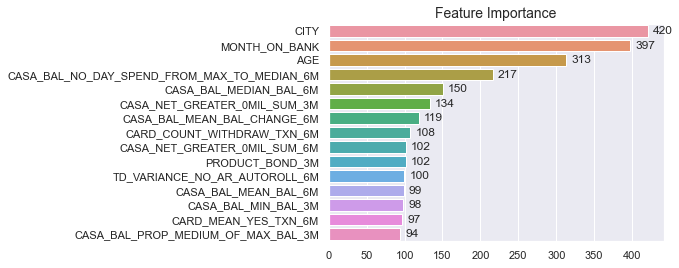

In [14]:
bst.plot_feature_importance(15)

In [27]:
importance = pd.Series(
    data=bst.booster.feature_importance(importance_type='gain'),
    index=bst.booster.feature_name(),
    name='importance'
)
importance = importance.sort_values(ascending=False).head(10)

In [29]:
importance

CASA_BAL_MEAN_BAL_INCREASE_GREATER_1E6_3M          115.152449
CITY                                               110.932200
MONTH_ON_BANK                                       92.234651
CARD_RATIO_SUM_YES_TXN_3M                           86.486158
CARD_MAX_PURCHASE_TXN_6M                            84.208122
AGE                                                 83.259731
CASA_OUTFLOW_STMT_ID_UNIQUE_GREATER_0MIL_SUM_1M     81.590151
CASA_BAL_NO_DAY_SPEND_FROM_MAX_TO_MEDIAN_3M         79.186670
PRODUCT_BOND_3M                                     77.298600
CASA_BAL_MAX_BAL_CHANGE_6M                          72.402401
Name: importance, dtype: float64

In [33]:
sns.set()

In [36]:
import matplotlib.pyplot as plt

In [56]:
ax.containers[0]

<BarContainer object of 10 artists>

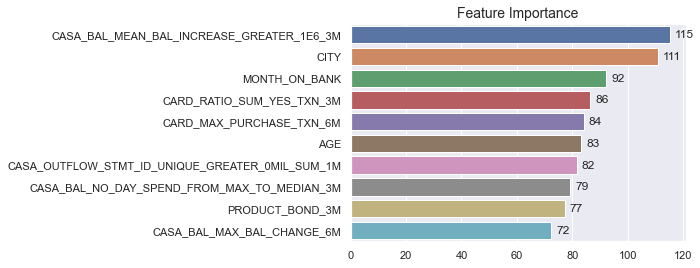

In [70]:
ax = sns.barplot(x=importance, y=importance.index)
plt.xlabel('')
plt.title('Feature Importance', size=14)
ax.bar_label(ax.containers[0], fmt='%.0f', padding=5);

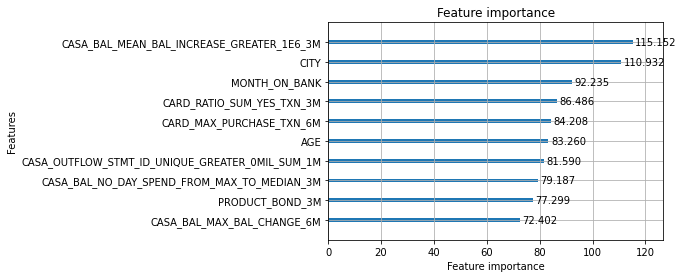

In [20]:
bst.plot_feature_importance()

In [9]:
mlframework.get_f1_score(y_valid, mlframework.predict(X_valid))

AttributeError: module 'mlframework.mlframework' has no attribute 'predict'

In [23]:
bst.booster.feature_name()

['TD_MAX_TD_AVG_BAL_6M',
 'TD_MEAN_TD_AVG_BAL_6M',
 'TD_MAX_NO_AR_TD_6M',
 'TD_MAX_TD_AVG_BAL_3M',
 'TD_MEAN_TD_AVG_BAL_3M',
 'TD_VARIANCE_TD_AVG_BAL_6M',
 'TD_MEDIAN_BAL_6M',
 'TD_MIN_TD_AVG_BAL_6M',
 'TD_VARIANCE_NO_AR_AUTOROLL_6M',
 'TD_MAX_NO_AR_AUTOROLL_6M',
 'LENDING_MAX_BAL_6M',
 'LENDING_VARIANCE_BAL_6M',
 'LENDING_MEAN_BAL_6M',
 'LENDING_VARIANCE_BAL_3M',
 'LENDING_MAX_BAL_3M',
 'LENDING_MIN_BAL_6M',
 'LENDING_SUM_BAL_6M',
 'LENDING_MIN_BAL_3M',
 'LENDING_MEAN_BAL_3M',
 'LENDING_SUM_BAL_3M',
 'MEET_COUNT_OTHER_BANCA_MAX_3M',
 'MEET_COUNT_OTHER_BANCA_MEAN_3M',
 'MEET_COUNT_OTHER_BANCA_3M',
 'MEET_COUNT_BIG_LENDING_MAX_3M',
 'MEET_COUNT_BIG_LENDING_MEAN_3M',
 'MEET_COUNT_BIG_LENDING_3M',
 'MEET_COUNT_CREDIT_NORMAL_MAX_3M',
 'MEET_COUNT_CREDIT_NORMAL_MEAN_3M',
 'MEET_COUNT_CREDIT_NORMAL_3M',
 'MEET_COUNT_SAVINGS_MAX_3M',
 'MEET_COUNT_SAVINGS_MEAN_3M',
 'MEET_COUNT_SAVINGS_3M',
 'MEET_COUNT_BOND_MAX_3M',
 'MEET_COUNT_BOND_MEAN_3M',
 'MEET_COUNT_BOND_3M',
 'MEET_COUNT_LENDING_MAX_3

In [29]:
bst.booster.feature_importance(importance_type='gain')

array([1.52050779e+01, 4.54393020e+01, 3.63476313e+01, 2.92698002e+00,
       8.60763592e+00, 7.01356936e+01, 1.20422939e+01, 2.30356831e+01,
       9.32637923e+01, 1.19792369e+01, 2.27403718e+01, 2.94716682e+01,
       1.48536880e+01, 4.45146006e+00, 1.76882099e+01, 0.00000000e+00,
       8.08239299e+00, 2.40479473e+01, 4.53750992e+00, 2.30598497e+00,
       2.56210101e+01, 3.11753754e+01, 5.03827212e+01, 0.00000000e+00,
       5.37199414e+00, 6.46475971e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.95596734e+01, 3.60076010e-01, 2.28467205e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.37253302e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.89575430e+01, 1.06243931e+01, 3.29739234e+01,
       0.00000000e+00, 0.00000000e+00, 3.01022005e+00, 1.67171100e+01,
       8.08166501e+00, 9.20538619e+00, 7.78536999e+00, 9.26864505e+00,
       2.06824690e+01, 3.92401898e+00, 0.00000000e+00, 8.23378113e+00,
      

In [9]:
bst.save_model('banca_model_20211005.pkl')

In [12]:
abc = model.LightGBM()
abc.load_model('banca_model_20211005.pkl')

In [32]:
random.shuffle(x)

0.7424825174825174

In [20]:
(
    grid_search_results
    .sort_values('metric_valid_max', ascending=False)
    .drop(['metric_valid_last', 'metric_valid_max', 'metric_valid_max_index', 'gap_at_valid_max'], axis=1)
    .iloc[0]
    .to_dict()
)

{'learning_rate': 0.1,
 'max_leaves': 1024,
 'objective': 'binary',
 'metric': 'auc',
 'verbose': -1}

In [8]:
best_model_index = grid_search.sort_values(criteria, ascending=1 - higher_better).head(1).index[0]
best_model_params = convert_params_to_list_dict(params_dict)[best_model_index]

booster = lgb.train(
    params=best_model_params,
    train=train,
    num_boost_round=grid_search.loc[best_model_index]['metric_valid_max_index'] + 1,
    verbose_eval=F

AttributeError: 'NoneType' object has no attribute 'predict'

In [ ]:
random.shuffle(list1)

In [8]:
grid_search

,learning_rate,max_leaves,objective,metric,verbose,metric_val_last,metric_val_max,metric_val_max_index,gap_at_val_max
0,0.1,64,binary,auc,-1,0.640783,0.670509,0,0.166083
1,0.1,256,binary,auc,-1,0.609884,0.683976,20,0.309629
2,0.1,1024,binary,auc,-1,0.621128,0.669902,35,0.324569
3,0.2,64,binary,auc,-1,0.568390,0.734652,2,0.185186
4,0.2,256,binary,auc,-1,0.645151,0.693845,11,0.299670
5,0.2,1024,binary,auc,-1,0.672005,0.709051,14,0.285067


In [30]:
params={'learning_rate': 0.2, 'max_leaves': 1024, 'objective': 'binary', 'metric': 'auc'}

In [32]:
evals_result

{'train': OrderedDict([('auc',
               [0.9205950243788019,
                0.9515667056808684,
                0.9695284170497268,
                0.9782565761344807,
                0.9831135397988541,
                0.9864338063308904,
                0.9887733347241133,
                0.990455507793089,
                0.9916322876627139,
                0.9927643260704792])]),
 'val': OrderedDict([('auc',
               [0.5482488069238858,
                0.5978726846234733,
                0.5862654695462266,
                0.595729191943703,
                0.6313192590795115,
                0.6567985116881015,
                0.653158618458303,
                0.648386314001456,
                0.6711154250586427,
                0.6565558521394483])])}

In [38]:
evals_result = {}
booster = lgb.train(
    params=params,
    train_set=train,
    num_boost_round=10,
    valid_sets=[train, val],
    valid_names=['train', 'val'],
    verbose_eval=1,
    evals_result=evals_result
)

[LightGBM] [Info] Number of positive: 341, number of negative: 11077
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 73303
[LightGBM] [Info] Number of data points in the train set: 11418, number of used features: 554
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029865 -> initscore=-3.480744
[LightGBM] [Info] Start training from score -3.480744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	train's auc: 0.920595	val's auc: 0.548249
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	train's auc: 0.951567	val's auc: 0.597873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	train's auc: 0.969528	val's auc: 0.586265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [18]:
a = model.train(train, params={'learning_rate': 0.2, 'max_leaves': 1024, 'objective': 'binary', 'metric': 'auc'}, num_boost_round=14)

[LightGBM] [Info] Number of positive: 341, number of negative: 11077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73303
[LightGBM] [Info] Number of data points in the train set: 11418, number of used features: 554
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029865 -> initscore=-3.480744
[LightGBM] [Info] Start training from score -3.480744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [9]:
booster = model.get_best_model(train=train, params_dict=params_dict, grid_search=grid_search, criteria='metric_val_max')

In [59]:
params1={
    'max_leaves': 64,
    'objective': 'binary',
    'metric': 'auc',
    'verbose': -1
}
params2={
    'max_leaves': 60,
    'objective': 'abc',
    'metric': 'zxv',
    'verbose': -2
}

In [72]:
pd.DataFrame([params1, params2]).iloc[0].to_dict()

{'max_leaves': 64, 'objective': 'binary', 'metric': 'auc', 'verbose': -1}

In [57]:
params.update(params)

In [58]:
params

{'max_leaves': 64, 'objective': 'binary', 'metric': 'auc', 'verbose': -1}

In [47]:
evals_result = {}
booster = lgb.train(
    params=params,
    train_set=train,
    num_boost_round=100,
    valid_sets=[train, val],
    valid_names=['train', 'val'],
    early_stopping_rounds=10,
    verbose_eval=False,
    evals_result=evals_result
)

In [49]:
evals_result['a'] = 9

In [50]:
evals_result

{'train': OrderedDict([('auc',
               [0.8147678621822373,
                0.8768427888516215,
                0.8918853152963816,
                0.9089427978438376,
                0.9173831718060076,
                0.9303648740713982,
                0.9401516186118661,
                0.9460012236669947,
                0.9595053555514496,
                0.9647809617939652,
                0.9713892041059444,
                0.9735026340455669,
                0.9770898026973021,
                0.9804007263222898,
                0.9827919561387165,
                0.9839390467680758,
                0.9847330568637171,
                0.985643810284452,
                0.9863162829339917])]),
 'val': OrderedDict([('auc',
               [0.42549947423764456,
                0.5032071503680337,
                0.46514195583596213,
                0.47534174553102,
                0.531335436382755,
                0.5105152471083071,
                0.4943743427970557,
  

In [51]:
params.update(evals_result)

In [52]:
params

{'max_leaves': 64,
 'objective': 'binary',
 'metric': 'auc',
 'verbose': -1,
 'train': OrderedDict([('auc',
               [0.8147678621822373,
                0.8768427888516215,
                0.8918853152963816,
                0.9089427978438376,
                0.9173831718060076,
                0.9303648740713982,
                0.9401516186118661,
                0.9460012236669947,
                0.9595053555514496,
                0.9647809617939652,
                0.9713892041059444,
                0.9735026340455669,
                0.9770898026973021,
                0.9804007263222898,
                0.9827919561387165,
                0.9839390467680758,
                0.9847330568637171,
                0.985643810284452,
                0.9863162829339917])]),
 'val': OrderedDict([('auc',
               [0.42549947423764456,
                0.5032071503680337,
                0.46514195583596213,
                0.47534174553102,
                0.53133543638275

In [48]:
evals_result

{'train': OrderedDict([('auc',
               [0.8147678621822373,
                0.8768427888516215,
                0.8918853152963816,
                0.9089427978438376,
                0.9173831718060076,
                0.9303648740713982,
                0.9401516186118661,
                0.9460012236669947,
                0.9595053555514496,
                0.9647809617939652,
                0.9713892041059444,
                0.9735026340455669,
                0.9770898026973021,
                0.9804007263222898,
                0.9827919561387165,
                0.9839390467680758,
                0.9847330568637171,
                0.985643810284452,
                0.9863162829339917])]),
 'val': OrderedDict([('auc',
               [0.42549947423764456,
                0.5032071503680337,
                0.46514195583596213,
                0.47534174553102,
                0.531335436382755,
                0.5105152471083071,
                0.4943743427970557,
  

In [39]:
metric = list(evals_result['train'].keys())[-1]
metric_train = evals_result['train'][metric]
metric_val = evals_result['val'][metric]
metric_gap = [x - y for x, y in zip(metric_train, metric_val)]

evals_result['metric_val_last'] = metric_val[-1]
evals_result['metric_val_max'] = max(metric_val)
evals_result['metric_val_max_index'] = metric_val.index(metric_val_max)
evals_result['gap_at_val_max'] = metric_gap[metric_val_max_index]



overfit_max_metric = [
    metric_val_last, metric_val_max, metric_val_max_index, gap_at_val_max]
grid_search_i = list(params.values()) + overfit_max_metric

# append loop result
grid_search.append(grid_search_i)

,0,gap_at_val_max,learning_rate,max_leaves,metric,metric_val_last,metric_val_max,metric_val_max_index,objective,verbose
0,NaN,0.408621,0.1,64.0,auc,0.500946,0.586330,89.0,binary,-1.0
1,NaN,0.361739,0.1,256.0,auc,0.461935,0.617666,4.0,binary,-1.0
2,NaN,0.331715,0.1,1024.0,auc,0.458780,0.650999,5.0,binary,-1.0
3,NaN,0.364791,0.2,64.0,auc,0.505783,0.620400,11.0,binary,-1.0
4,NaN,0.463145,0.2,256.0,auc,0.407571,0.532492,59.0,binary,-1.0
5,NaN,0.481728,0.2,1024.0,auc,0.387592,0.490116,2.0,binary,-1.0
0,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,binary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,auc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
evals_result.keys()

dict_keys(['train', 'val'])